### ============================================================================
# **REINFORCEMENT LEARNING ALGO AGENT on FX-EUR/USD FIN TRADING**
###### 500k+ steps/hour
###### Built on i5 3rd-gen/4GB DDR3
### =============================================================================

## 0.0 project setup

In [1]:
# for data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# for the RL-Algo Trading Agent
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# other utils
import random
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.0 data handling

In [14]:
# load data
df_raw = pd.read_csv("/content/sample_data/eurusd_5yrs_daily.csv")

# split data train/test
total_rows = len(df_raw)                                                         # 1304 rows
train_size = int(0.7 * total_rows)                                               # 912 rows
# test_size  = total_rows - train_size                                           # 392 rows
train_raw = df_raw.iloc[:train_size].reset_index(drop=True)
test_raw  = df_raw.iloc[train_size:].reset_index(drop=True)

# Keep raw closes for PnL
close_prices_train = train_raw['close'].values
close_prices_test  = test_raw['close'].values

# Scaling/Normalization
scaler = MinMaxScaler()
scaler.fit(train_raw[['open', 'high', 'low', 'close']])    # fit on train data onlyonly!
train_scaled = pd.DataFrame(scaler.transform(train_raw[['open', 'high', 'low', 'close']]), columns=['open', 'high', 'low', 'close'])
test_scaled  = pd.DataFrame(scaler.transform(test_raw[['open', 'high', 'low', 'close']]), columns=['open', 'high', 'low', 'close'])

# Final datasets for training and testing
df_train = train_scaled
df_test  = test_scaled

In [19]:
df_test.head()

,open,high,low,close
0,0.431577,0.440042,0.449175,0.431577
1,0.440573,0.437911,0.445220,0.440573
2,0.426783,0.421131,0.406056,0.426783
3,0.366743,0.372843,0.396598,0.366743
4,0.343331,0.336237,0.335626,0.343331


## 2.0 environment design

Create a State

In [3]:
window = 30

def create_state(idx, df, raw_close_prices):

    if idx < window:
        return None

    # log returns from scaled close-prices
    scaled_close = df['close'].iloc[idx-window:idx].values
    ratio = scaled_close[1:] / (scaled_close[:-1] + 1e-8)
    ratio = np.clip(ratio, 0.9, 1.1)
    returns = np.log(ratio)
    returns = np.nan_to_num(returns, 0.0)

    # some padding
    padded_returns = np.zeros(window - 1)
    padded_returns[-len(returns):] = returns

    # features from raw close prices
    raw_window = raw_close_prices[idx-window:idx]
    raw_close = raw_window[-1]
    rsi = compute_rsi(raw_window)
    macd = compute_macd(raw_window)
    ema20 = pd.Series(raw_window).ewm(span=20, adjust=False).mean().iloc[-1]
    ema50 = pd.Series(raw_window).ewm(span=50, adjust=False).mean().iloc[-1]
    ema20_dist = (raw_close - ema20) / raw_close
    ema50_dist = (raw_close - ema50) / raw_close
    vol = np.std(returns[-20:]) if len(returns) >= 5 else 0.0
    momentum = returns[-1] if len(returns) > 0 else 0.0

    # feature vector
    features = np.array([rsi/100.0, macd, ema20_dist, ema50_dist, vol, momentum])

    # state vector
    state = np.concatenate([padded_returns, features]).astype(np.float32)

    return state


# util functions
def compute_rsi(prices, period=14):
    prices = pd.Series(prices)
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    roll_up = gain.ewm(com=period-1, min_periods=period).mean()
    roll_down = loss.ewm(com=period-1, min_periods=period).mean()
    rs = roll_up / (roll_down + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return float(rsi.iloc[-1]) if not rsi.empty else 50.0

def compute_macd(prices, fast=12, slow=26):
    prices = pd.Series(prices)
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    return float(macd_line.iloc[-1])

## 3.0 rl-algo architecture

The Neural Network

In [4]:
class DuelingDDQN(nn.Module):

    def __init__(self, state_size, action_size=3, hidden=256):

        super().__init__()

        self.shared = nn.Sequential(
            nn.Linear(state_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        # Value stream
        self.value = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )

        # Advantage stream
        self.advantage = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, action_size)
        )

    def forward(self, x):
        base = self.shared(x)
        value = self.value(base)
        advantage = self.advantage(base)
        # Q = V + (A - mean(A))
        q = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q

Buffer

In [5]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity=50_000, alpha=0.6, beta=0.4, beta_anneal=0.001):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha
        self.beta = beta
        self.beta_anneal = beta_anneal

    def push(self, state, action, reward, next_state, done):
        max_prio = max(self.priorities, default=1.0)
        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max_prio ** self.alpha)

    def sample(self, batch_size):
        prios = np.array(self.priorities) + 1e-6
        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=False)
        samples = [self.buffer[i] for i in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        self.beta = min(1.0, self.beta + self.beta_anneal)

        states, actions, rewards, next_states, dones = zip(*samples)
        return (torch.FloatTensor(np.array(states)).to(device),
                torch.LongTensor(actions).to(device),
                torch.FloatTensor(rewards).to(device),
                torch.FloatTensor(np.array(next_states)).to(device),
                torch.FloatTensor(dones).to(device),
                torch.FloatTensor(weights).to(device),
                indices)

    def update_priorities(self, indices, td_errors):
        for i, error in zip(indices, td_errors):
            self.priorities[i] = (error + 1e-6) ** self.alpha

    def __len__(self):
        return len(self.buffer)

Training loop

In [ ]:
# feed-in initializations
state_size = window - 1 + 6
action_size = 3

# The Neural Nets Architecture
policy_net = DuelingDDQN(state_size, action_size).to(device)
target_net = DuelingDDQN(state_size, action_size).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=0.0005)
target_net.load_state_dict(policy_net.state_dict())
buffer = PrioritizedReplayBuffer()
target_update = 100

# some training params
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

episodes = 50
batch_size = 64
all_rewards = []
best_reward = -np.inf

In [15]:
# actual training loop
for ep in range(episodes):

    ep_reward = 0.0
    position = 0                                                                                            # 0=flat, 1=long, -1=short

    for idx in range(window, len(df_train)-1):

        # ========================== CREATE STATE ==========================
        state = create_state(idx, df_train, close_prices_train)
        if state is None: continue

        # ========================== GET ACTION USING GREEDY EPSILON  ==========================
        if random.random() < epsilon:
            action = random.randint(0, 2)
        else:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).argmax().item()

        # capture new position usin chosen action
        new_position = 1 if action == 1 else -1 if action == 2 else 0

        # ========================== COMPUTE REWARD USING RAW (NON-SCALED) CLOSE PRICES ==========================
        raw_diff = close_prices_train[idx+1] - close_prices_train[idx]
        price_move_pips = raw_diff * 10000

        # gross reward: what the current position made
        reward = position * price_move_pips

        # transaction cost (when changing position, Spread/Slippage = 1.0 pips)
        if new_position != position:
            reward -= 1.0

        # ========================== REWARD SHAPING TO AID MODEL CONVERGENCE ==========================
        # A) reward model for being on the right side of a big move (even if small profit)
        if abs(price_move_pips) > 25:  # Big daily move (25 pips)
            if (position == 1 and price_move_pips > 0) or (position == -1 and price_move_pips < 0):
                reward += 18.0 # HUGE reward for catching trends
            # If we missed it → HUGE penalty (encourages learning trends)
            elif position != 0:
                reward -= 8.0

        # B)
        if position != 0:
            # bonus for holding a winning position longer (good job, keep holding winner)
            if (position == 1 and price_move_pips > 0) or (position == -1 and price_move_pips < 0):
                reward += 0.8
            # penalty for holding a losing position (encourages cutting losses)
            if (position == 1 and price_move_pips < -12) or (position == -1 and price_move_pips > 12):
                reward -= 1.5
            # tiny "momentum continuation" bonus
            if abs(price_move_pips) > 8:
                if (position == 1 and price_move_pips > 0) or (position == -1 and price_move_pips < 0):
                    reward += 0.6

        # C) bonus for being flat during chop (reduces overtrading)
        if position == 0 and abs(price_move_pips) < 15:
            reward += 0.8  # "smart, stayed out of noise"

        # final reward/new position
        ep_reward += reward
        position = new_position

        # getting the next state
        next_state = create_state(idx + 1, df_train, close_prices_train)
        if next_state is None: next_state = state

        # ========================== OPTIMIZING MODEL (WITH BUFFER REPLAY) ==========================
        # storing policy chosen, transistions and reward obtained to buffer
        buffer.push(state, action, reward, next_state, 0.0)

        # sampling histories from buffer to optimize model, if buffer has more than 250 histories
        if len(buffer) > 1000:

            states, actions, rewards, next_states, dones, weights, indices = buffer.sample(batch_size)

            # obtain current Q values
            current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                next_actions = policy_net(next_states).argmax(1, keepdim=True)
                # target net evaluates that action (to counter bias)
                next_q = target_net(next_states).gather(1, next_actions).squeeze(1)
                # final Bellman target
                target = rewards + gamma * next_q * (1 - dones)

            # actual optimization of current q values against the target values with prioritized/importance sampling
            loss = (weights * F.mse_loss(current_q, target, reduction='none')).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update priorities on buffer
            td_error = torch.abs(current_q - target).detach().cpu().numpy()
            buffer.update_priorities(indices, td_error)

    # ========================== UPDATE PARAMS ON EPISODE END ==========================
    all_rewards.append(ep_reward)
    # epsilon decay after episode's end to faciliate exploration/exploitation of rl env
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    # update TARGET NET after every five episodes
    if (ep + 1) % 5 == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # verbose: see episode reward
    print(f"Episode {ep+1:2d} | Reward: {ep_reward:8,.1f} pips | ε: {epsilon:.3f}")

    # ========================== STORING THE BEST MODEL POLICIES BASED ON EPISODE REWARD ==========================
    if ep_reward > best_reward:
        best_reward = ep_reward
        torch.save(policy_net.state_dict(), "best_dueling_ddqn_per.pth")
        print(f"NEW BEST → {best_reward:,.0f} pips")

Episode  1 | Reward:  3,122.1 pips | ε: 0.603
Episode  2 | Reward:    855.4 pips | ε: 0.600
Episode  3 | Reward:  2,405.0 pips | ε: 0.597
Episode  4 | Reward:  2,284.1 pips | ε: 0.594
Episode  5 | Reward:  1,974.0 pips | ε: 0.591
Episode  6 | Reward:  2,026.2 pips | ε: 0.588
Episode  7 | Reward:  3,564.2 pips | ε: 0.585
Episode  8 | Reward:  1,599.4 pips | ε: 0.582
Episode  9 | Reward:    -35.3 pips | ε: 0.579
Episode 10 | Reward:  2,644.1 pips | ε: 0.576
Episode 11 | Reward:  3,101.4 pips | ε: 0.573
Episode 12 | Reward:  1,604.1 pips | ε: 0.570
Episode 13 | Reward:  3,196.9 pips | ε: 0.568
Episode 14 | Reward:    611.0 pips | ε: 0.565
Episode 15 | Reward:  4,284.4 pips | ε: 0.562
Episode 16 | Reward:  2,494.3 pips | ε: 0.559
Episode 17 | Reward:  3,433.2 pips | ε: 0.556
Episode 18 | Reward:  3,198.0 pips | ε: 0.554
Episode 19 | Reward:  2,337.4 pips | ε: 0.551
Episode 20 | Reward:  2,715.1 pips | ε: 0.548
Episode 21 | Reward:  2,249.7 pips | ε: 0.545
Episode 22 | Reward:  3,976.3 pips

## 4.0 evaluation

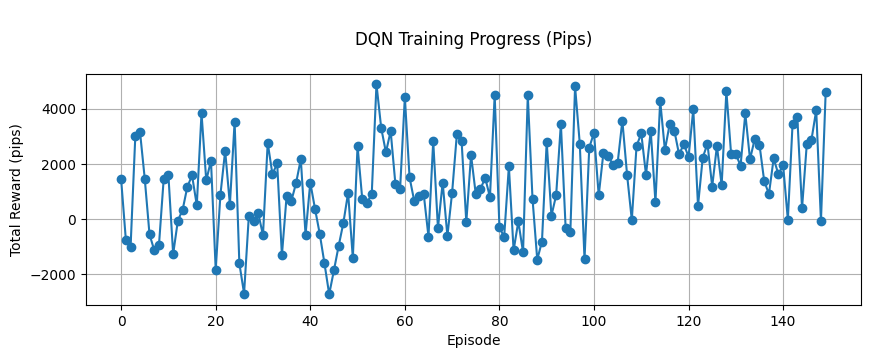



Best DQN episode: 4,881 pips



In [16]:
# === FINAL REWARD PLOT ===
plt.figure(figsize=(10,3))
plt.plot(all_rewards, marker='o')
plt.title("\nDQN Training Progress (Pips)\n")
plt.xlabel("Episode")
plt.ylabel("Total Reward (pips)")
plt.grid(True)
plt.show()

print(f"\n\nBest DQN episode: {max(all_rewards):,.0f} pips\n")

## 5.0 backtesting

In [17]:
# Backtest function
def backtest(model_path="best_dueling_ddqn_per.pth", test=True):

    policy_net = DuelingDDQN(state_size, action_size).to(device)
    policy_net.load_state_dict(torch.load(model_path, map_location=device))
    policy_net.eval()

    data = df_test if test else df_train
    prices = close_prices_test if test else close_prices_train
    name = "UNSEEN TEST" if test else "TRAIN"

    position = 0
    pnl = 0.0
    trades = 0

    with torch.no_grad():
        for i in range(window, len(data)-1):
            state = create_state(i, data, prices)
            if state is None: continue
            action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).argmax().item()
            new_pos = 1 if action == 1 else -1 if action == 2 else 0
            diff = (prices[i+1] - prices[i]) * 10000
            pnl += position * diff
            if new_pos != position:
                pnl -= 1.0
                trades += 1
            position = new_pos

    print(f"BACKTEST {name} → {pnl:,.0f} pips | {trades} trades")
    return pnl

In [18]:
backtest(test=True)

BACKTEST UNSEEN TEST → 1,292 pips | 222 trades


np.float64(1292.0354633331342)

## The End.